In [25]:
import io
import nltk
import string
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

In [2]:
fake = pd.read_csv('Fake.csv')  # Fake News
real = pd.read_csv('True.csv')  # Real News

In [3]:
real['is_fake'] = 0
fake['is_fake'] = 1   # Dependent Variable for Classifying Data
data = pd.concat([real,fake])   # Merging Real & Fake News Data
data = data.sample(frac=1)   # Shuffle the Data
data = data.reset_index()
data.drop(['date','subject','index'], axis=1, inplace=True)

In [4]:
X, y = data.drop(['is_fake'],axis=1), data['is_fake']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Splitting into Train & Test data

In [5]:
train_real = X_train.loc[(y_train==0),:]
train_fake = X_train.loc[(y_train==1),:]

## Lexical Diversity of Fake News

Let's define a measure for lexical diversity to find out how many unique vocabs are used in Fake News articles.

Lexical diversity = No. of unique words in target category / No. of words in both categories

In [6]:
def lexical_diversity(data, other_data, feature):
    column = data[feature].str.lower() 
    text = ' '.join(column)
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude) # Extract words from the column specified
    words_splitted = words.split()
    
    other_column = other_data[feature].str.lower() 
    other_text = ' '.join(other_column)
    other_words = ''.join(char for char in other_text if char not in exclude) # Extract words from the other column
    other_words_splitted = other_words.split()

    return len(set(words_splitted)) / (len(words_splitted) + len(other_words_splitted))

print(f'Real News: {lexical_diversity(train_real, train_fake, "text"):.4f}')
print(f'Fake News: {lexical_diversity(train_fake, train_real, "text"):.4f}')

Real News: 0.0063
Fake News: 0.0115


## Most frequently used words in Titles

Is there a difference between the most frequently used words in the titles of Real News and Fake News? This question might already reveal the topics of the Fake News articles.


In [6]:
stopwords = set(STOPWORDS)

def common_tokens_title(data, feature, name):
    column = data[feature].str.lower()
    text = ' '.join(column)
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)  # Extract words from News Titles
    words_splitted = words.split()
    words_stopped = [word for word in words_splitted if not word in stopwords]
    print(f'{name}:-\n{pd.DataFrame(nltk.FreqDist(words_stopped).most_common(10))[0]}\n')  # Top 10 common words
    
common_tokens_title(train_real, 'title', 'Common words in Real News Titles')
common_tokens_title(train_fake, 'title', 'Common words in Fake News Titles')

Common words in Real News Titles:-
0     trump
1        us
2      says
3     house
4     north
5       new
6     white
7    russia
8     korea
9    senate
Name: 0, dtype: object

Common words in Fake News Titles:-
0        video
1        trump
2        watch
3        obama
4      hillary
5      trump’s
6    president
7           us
8      clinton
9         will
Name: 0, dtype: object



## Punctutation

Punctuation might provide some information for predictions.

In [7]:
def count_punc(text):
    peri = re.subn(r"\.", '', text)[1] # count of (.)
    comm = re.subn(r"\,", '', text)[1] # count of (,)
    ques = re.subn(r"\?", '', text)[1] # count of (?)
    excl = re.subn(r"\!", '', text)[1] # count of (!)
    return [peri,comm, ques, excl]

def punc_df(df, feat):
    return df.apply(lambda row: pd.Series({'peri_' + feat:count_punc(row[feat])[0], 'comm_' + feat:count_punc(row[feat])[1],'ques_' + feat:count_punc(row[feat])[2],'excl_' + feat:count_punc(row[feat])[3]}), axis=1)

punc_train_title = punc_df(X_train, 'title')
punc_test_title = punc_df(X_test, 'title')
punc_train_text = punc_df(X_train, 'text')
punc_test_text = punc_df(X_test, 'text')

In [8]:
title_punc_count = 0
text_punc_count = 0

for row in punc_train_title.itertuples():
    title_punc_count += (row.peri_title + row.comm_title + row.ques_title + row.excl_title)/4
for row in punc_test_title.itertuples():
    title_punc_count += (row.peri_title + row.comm_title + row.ques_title + row.excl_title)/4
for row in punc_train_text.itertuples():
    text_punc_count += (row.peri_text + row.comm_text + row.ques_text + row.excl_text)/4
for row in punc_test_text.itertuples():
    text_punc_count += (row.peri_text + row.comm_text + row.ques_text + row.excl_text)/4
    
print('Average puncutations in Title : ',title_punc_count/(punc_train_title.shape[0]+punc_test_title.shape[0]))
print('Average puncutations in Text : ',text_punc_count/(punc_train_text.shape[0]+punc_test_text.shape[0]))

Average puncutations in Title :  0.1550347454229587
Average puncutations in Text :  10.560392445097778


## Text Length

No. of characters present in Titles of news and their respective Text content.

In [9]:
def len_df(df):
    return df.apply(lambda row: pd.Series({'title_len':len(row['title']), 'text_len':len(row['text'])}), axis=1)

train_len = len_df(X_train)
test_len = len_df(X_test)
print('Text Length :-\n ',(train_len.mean()+test_len.mean())/2)

Text Length :-
  title_len      80.100268
text_len     2465.756176
dtype: float64


## Number of Words in the Title

Let's create a feature which counts the number of words in the Title. Titles are extremely important when it comes to grabbing Attention.

In [10]:
def words_df(df):
    return df.apply(lambda row: pd.Series({'title_words':len(row['title'].split())}), axis=1)

train_words = words_df(X_train)
test_words = words_df(X_test)
print('No of words : ',train_words.mean()+test_words.mean()/2)

No of words :  title_words    18.678756
dtype: float64


## Ratio of Title Length / (Article + Title) Length

One could assume that some attention grabbing Fake News have a long title and very short texts. Let's include this as a feature too.

In [11]:
def ratio_df(df):
    return df.apply(lambda row: pd.Series({'title_ratio':len(row['title'])/(len(row['title']) + len(row['text']))}), axis=1)

ratio_train = ratio_df(X_train)
ratio_test = ratio_df(X_test)
print('Ratio : ',ratio_train.mean()+ratio_test.mean()/2)

Ratio :  title_ratio    0.108016
dtype: float64


## Creating DataFrame with Extracted Features

Let us now combine the above extracted features into a single DataFrame for our model to train on.

In [12]:
X_train_feat = pd.concat([punc_train_title, punc_train_text, train_len, train_words, ratio_train], axis=1)
X_test_feat = pd.concat([punc_test_title, punc_test_text, test_len, test_words, ratio_test], axis=1)

print(X_train_feat.head())

       peri_title  comm_title  ques_title  excl_title  peri_text  comm_text  \
36335           2           0           0           0         26         25   
12384           0           0           1           0          6          3   
24419           0           0           0           0          6          5   
24740           0           0           0           0         21         21   
27039           0           1           0           0         13         22   

       ques_text  excl_text  title_len  text_len  title_words  title_ratio  
36335          0          0         61      2964            9     0.020165  
12384          0          0         49       688            9     0.066486  
24419          0          0         59       765            9     0.071602  
24740          0          0         68      2371            9     0.027880  
27039          0          0        103      1757           15     0.055376  


## Removing Outliers

*   Many Titles don't contain any form of punctuation!
*   Some texts contain suspiciously small amounts of characters.

So let's remove some extreme outliers!

In [13]:
X_train_feat_zscore = X_train_feat.apply(stats.zscore, axis=0)
mask_outliers = np.logical_not(((X_train_feat_zscore>3).any(axis=1)).values + ((X_train_feat_zscore<-3).any(axis=1)).values) # Removing Data beyond +-3z values.
X_train_feat = X_train_feat.loc[mask_outliers,:]
y_train = y_train[X_train_feat.index]
y_test = y_test[X_test_feat.index]

## Correlation between Features

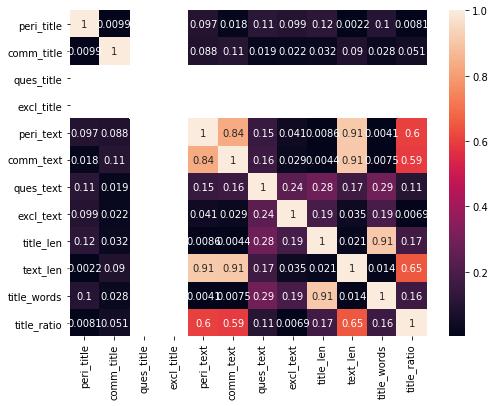

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(np.abs(X_train_feat.corr()), annot=True)
plt.show()

In [15]:
pd.concat([X_train_feat, y_train], axis=1).groupby('is_fake').mean()

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,title_len,text_len,title_words,title_ratio
is_fake,,,,,,,,,,,,
0,0.431641,0.203327,0.0,0.0,20.244766,18.829885,0.081036,0.043588,64.559764,2325.743017,9.926269,0.048718
1,0.077863,0.154307,0.0,0.0,19.623453,19.335330,0.851840,0.437544,89.080069,2370.135078,13.960123,0.052720


* Titles of Fake News contain ~5 times less dots.
* Texts of Fake News contain ~10 times more question marks.
* Texts of Fake News contain ~10 times more exclamation marks.
* Titles of Fake News are ~50% longer. The number of words seems to reflect that fact as well.
* $\frac {len(title)}{len(title)+len(text)}$ is ~10% longer in Fake News.
* Let's ignore the high correlations we found above. A more elaborate approach would be to eliminate correlating features by dropping them or using dimensionality reduction like PCA.

## Classification Model based on Extracted Features

Let us Try **RandomForest Model** for classification.

In [45]:
rf = RandomForestClassifier(random_state=42)
preds = cross_val_predict(rf, X_train_feat, y_train, cv=5)
rf_acc = accuracy_score(y_true=y_train, y_pred=preds)
rmse_rf = mean_squared_error(y_train,preds,squared = False)
print(f'\nTraining Accuracy :-\n\tf1 : {f1:.4f}\n\tacc: {rf_acc:.4f}')


Training Accuracy :-
	f1 : 0.9263
	acc: 0.9173


<br>
<b>XGBoost Classifer</b>
<br><br>

In [48]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train_feat, y_train)
predictions = xgb.predict(X_test_feat)
rmse_xgb = mean_squared_error(y_test,predictions,squared = False)
xgb_accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (xgb_accuracy * 100.0))

[12:27:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 91.58%


<br>
<b>KNNeighbors Classifier</b>
<br><br>

In [49]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train_feat, y_train)
predictions = neigh.predict(X_test_feat)
rmse_knn = mean_squared_error(y_test,predictions,squared = False)
knn_accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (knn_accuracy * 100.0))

Accuracy: 82.00%


<br>
<b>DecisionTree Classifier</b>
<br><br>

In [50]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train_feat, y_train)
predictions = dtree.predict(X_test_feat)
rmse_dt = mean_squared_error(y_test,predictions,squared = False)
dt_accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (dt_accuracy * 100.0))

Accuracy: 88.43%


## HyperParameter Tuning

In [51]:
from sklearn.model_selection import GridSearchCV
params= {'n_estimators':[200, 300], 'criterion':['gini', 'entropy'], 'max_depth':[5, None], 'max_features':[2,5]}
gscv = GridSearchCV(rf, params)
gscv.fit(X_train_feat, y_train)
gscv.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 2,
 'n_estimators': 300}

## Tuned Model

In [52]:
rf_tuned = RandomForestClassifier(criterion='gini', max_depth=None, max_features=2, n_estimators=200, random_state=12)
preds = cross_val_predict(rf_tuned, X_train_feat, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
rf_acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'\nTraining Accuracy :-\n\tf1 : {f1:.4f}\n\tacc: {rf_acc:.4f}')


Training Accuracy :-
	f1 : 0.9047
	acc: 0.9180


## Important Features

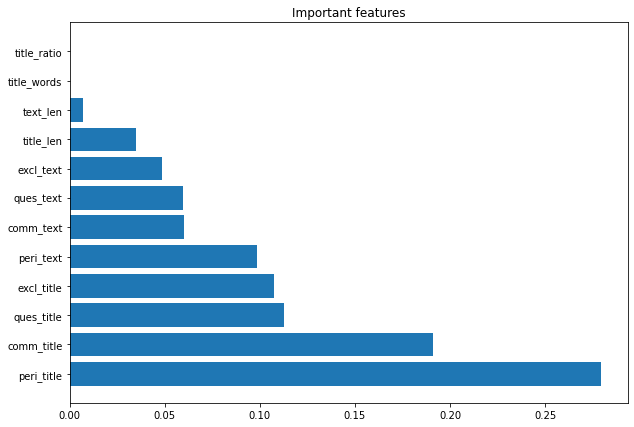

In [53]:
rf_tuned.fit(X_train_feat, y_train)
predictions = rf_tuned.predict(X_test_feat)
rmse_rf = mean_squared_error(y_test,predictions,squared = False)
feat = pd.Series(rf_tuned.feature_importances_, index=X_train_feat.columns).sort_values(ascending=False)
feat_cols = X_train_feat.columns
fig = plt.figure(figsize=(10,7))
plt.barh(feat_cols,feat)
plt.title("Important features")
plt.show()

## Prediction on Test Data

In [35]:
preds_test = rf_tuned.predict(X_test_feat) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'\nTesting Accuracy :-\n\tf1: {f1:.4f}\n\tacc: {acc:.4f}')


Testing Accuracy :-
	f1: 0.9263
	acc: 0.9238



## Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,preds_test)
print(cm)

[[4059  275]
 [ 419 4227]]


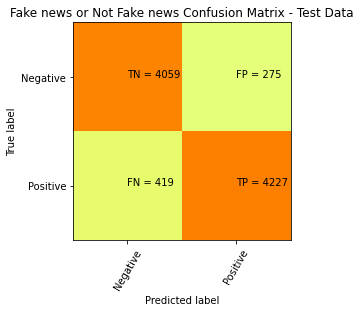

In [23]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Fake news or Not Fake news Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=60)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [24]:
from sklearn.metrics import classification_report

matrix = classification_report(y_test,preds_test,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.94      0.91      0.92      4646
           0       0.91      0.94      0.92      4334

    accuracy                           0.92      8980
   macro avg       0.92      0.92      0.92      8980
weighted avg       0.92      0.92      0.92      8980



## Data Visualization

In [32]:
df = pd.read_csv('Final.csv')
df.head()

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,title_len,text_len,title_words,title_ratio,is_fake
0,0,0,0,0,6,6,0,0,62,395,11,title_ratio,0
1,0,1,0,0,24,24,0,0,73,3419,11,title_ratio,0
2,2,0,0,0,42,36,0,0,53,4062,8,title_ratio,0
3,0,1,0,0,13,16,0,0,139,1908,20,title_ratio,1
4,0,0,0,0,12,10,0,0,80,1402,14,title_ratio,1


In [33]:
true = df[df['is_fake']==0]
fake = df[df['is_fake']==1]
fake_mean_title = fake[['peri_title','comm_title','ques_title','excl_title']].mean()
true_mean_title = true[['peri_title','comm_title','ques_title','excl_title']].mean()

In [34]:
fake_mean_text = fake[['peri_text','comm_text','ques_text','excl_text']].mean()
true_mean_text = true[['peri_text','comm_text','ques_text','excl_text']].mean()
columns = ['Periods(.)','Comma (,)','Question Mark (?)','Exclamation Mark (!)']

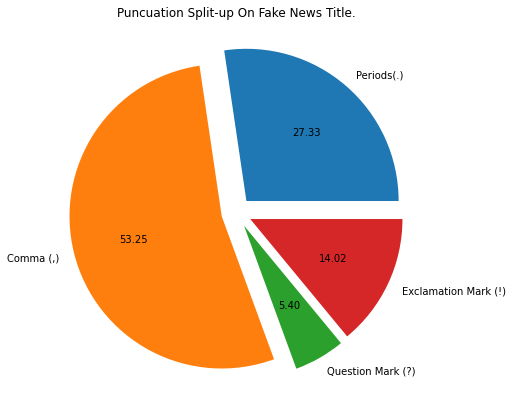

In [35]:
fig = plt.figure(figsize=(10,7))
plt.pie(fake_mean_title,normalize = True,labels = columns,explode = [0.1,0.1,0.1,0.1],autopct='%.2f')
plt.title('Puncuation Split-up On Fake News Title.')
plt.show()

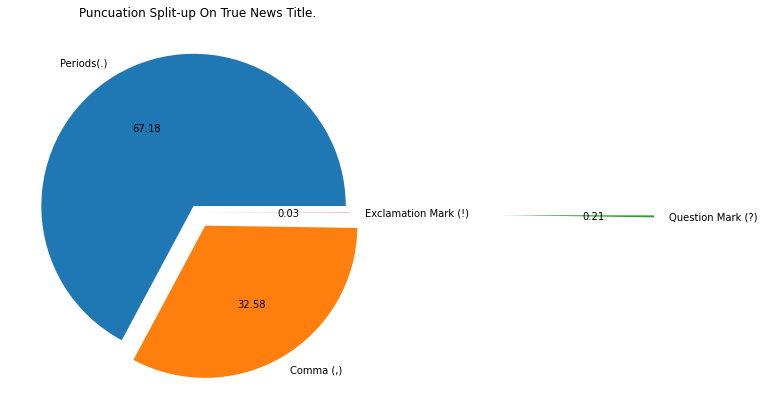

In [36]:
fig = plt.figure(figsize=(10, 7))
plt.pie(true_mean_title,normalize = True,labels = columns,explode = [0.05,0.1,2,0],autopct='%.2f')
plt.title('Puncuation Split-up On True News Title.')
plt.show()

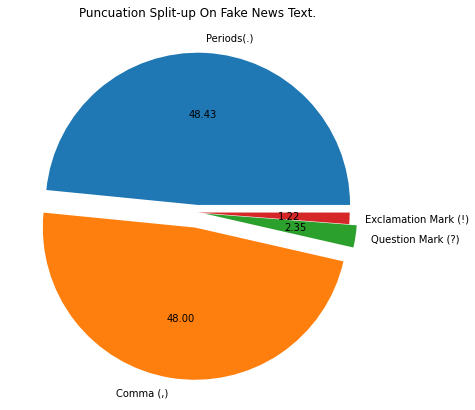

In [37]:
fig = plt.figure(figsize=(10,7))
plt.pie(fake_mean_text,normalize = True,labels = columns,explode = [0.05,0.1,0.05,0],autopct='%.2f')
plt.title('Puncuation Split-up On Fake News Text.')
plt.show()


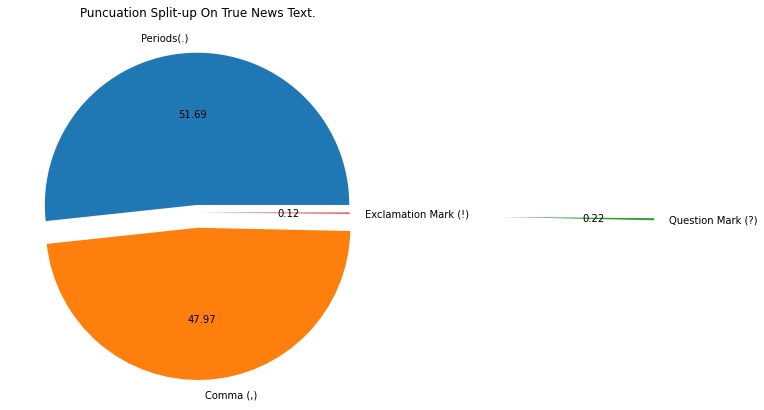

In [38]:
fig = plt.figure(figsize=(10,7))
plt.pie(true_mean_text,normalize = True,labels = columns,explode = [0.05,0.1,2,0],autopct='%.2f')
plt.title('Puncuation Split-up On True News Text.')
plt.show()

c:\users\aravindhan\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


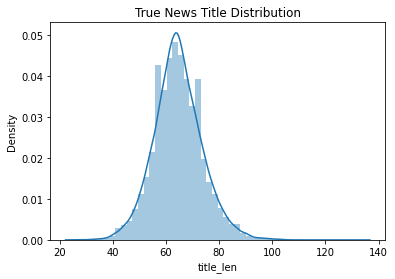

<Figure size 720x504 with 0 Axes>

In [39]:
sns.distplot(true['title_len'])
plt.title('True News Title Distribution')
fig = plt.figure(figsize=(10,7))
plt.show()

c:\users\aravindhan\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


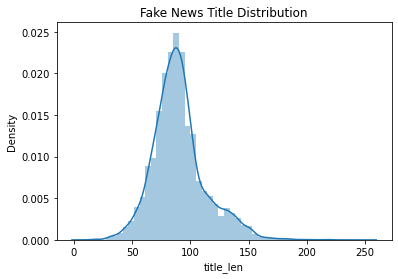

<Figure size 720x504 with 0 Axes>

In [40]:
sns.distplot(fake['title_len'])
plt.title('Fake News Title Distribution')
fig = plt.figure(figsize=(10,7))
plt.show()

<AxesSubplot:ylabel='count'>

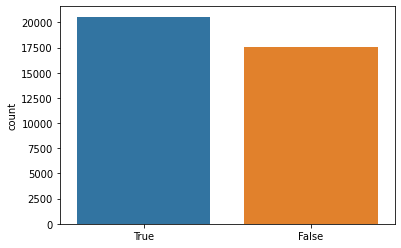

In [44]:
cnt = ['True' if i==0 else 'False' for i in df['is_fake']]
sns.countplot(x = cnt)

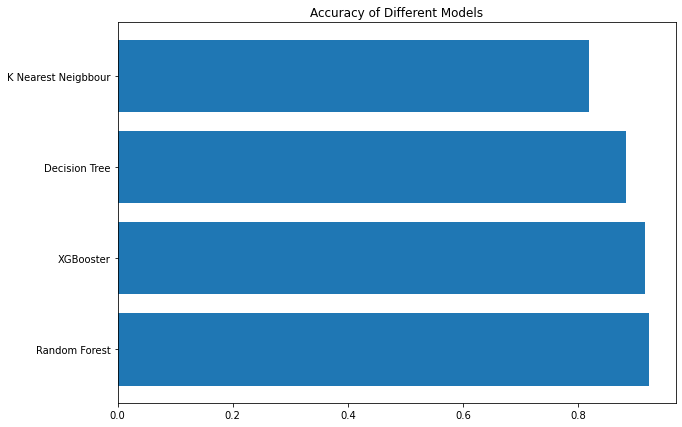

In [38]:
accuracy = [0.9238,xgb_accuracy,dt_accuracy,knn_accuracy]
acu_name = ["Random Forest","XGBooster","Decision Tree","K Nearest Neigbbour"]
fig = plt.figure(figsize=(10,7))
plt.barh(acu_name,accuracy)
plt.title('Accuracy of Different Models')
plt.show()

In [54]:
print(accuracy)

[0.9238, 0.9158129175946548, 0.882739420935412, 0.8200445434298441]


In [55]:
rmse_val = [rmse_rf,rmse_xgb,rmse_dt,rmse_knn]
print(rmse_val)

[0.27598779870386947, 0.2901501032316639, 0.340149318711716, 0.4242115705283814]
